In [3]:
!pip install --force https://github.com/chengs/tqdm/archive/colab.zip
!pip3 install torch torchvision

     \ 552kB 4.7MB/s
  Running setup.py bdist_wheel for tqdm ... - \ done
  Stored in directory: /tmp/pip-ephem-wheel-cache-9ge5yec9/wheels/41/18/ee/d5dd158441b27965855b1bbae03fa2d8a91fe645c01b419896
Successfully built tqdm
spacy 2.0.18 has requirement numpy>=1.15.0, but you'll have numpy 1.14.6 which is incompatible.
pymc3 3.6 has requirement joblib<0.13.0, but you'll have joblib 0.13.0 which is incompatible.
featuretools 0.4.1 has requirement pandas>=0.23.0, but you'll have pandas 0.22.0 which is incompatible.
  Found existing installation: tqdm 4.28.1
    Uninstalling tqdm-4.28.1:
      Successfully uninstalled tqdm-4.28.1
    100% |████████████████████████████████| 591.8MB 28kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x62478000 @  0x7fd8b16a42a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x5076

In [2]:
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
from bs4 import BeautifulSoup

from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from collections import Counter
import requests
import time
import warnings

from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from tqdm import tqdm_notebook as tqdm

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.autograd import Variable
from torch import optim

In [5]:
print("PyTorch version: ")
print(torch.__version__)
print("CUDA Version: ")
print(torch.version.cuda)
print("cuDNN version is: ")
print(torch.backends.cudnn.version())

PyTorch version: 
1.0.0
CUDA Version: 
9.0.176
cuDNN version is: 
7401


In [0]:
faculty = requests.get("https://www.seas.harvard.edu/faculty-research/people/ladder").text
faculty

'<!DOCTYPE html>\n<html lang="en" dir="ltr">\n<head>\n  <!--[if IE]><![endif]-->\n<meta http-equiv="Content-Type" content="text/html; charset=utf-8" />\n<link rel="shortcut icon" href="https://www.seas.harvard.edu/favicon.ico" type="image/vnd.microsoft.icon" />\n<meta name="viewport" content="width=device-width, initial-scale=1, maximum-scale=1, minimum-scale=1, user-scalable=no" />\n<script type="text/javascript">var _sf_startpt=(new Date()).getTime();</script>\n<meta name="description" content="The term ladder faculty refers to tenured full professors as well as tenure-track professorial faculty (assistant and associate professors)." />\n<meta name="generator" content="Drupal 7 (https://www.drupal.org)" />\n<link rel="canonical" href="https://www.seas.harvard.edu/faculty-research/people/ladder" />\n<link rel="shortlink" href="https://www.seas.harvard.edu/node/75181" />\n<meta name="twitter:card" content="summary" />\n<meta name="twitter:url" content="https://www.seas.harvard.edu/facu

In [0]:
def make_soup(page: str): 
    return BeautifulSoup(page, "html.parser")
        
soup = make_soup(faculty)

In [0]:
# this gives URLs of all professors' full profiles
profs = [prof.findAll("a")[0]["href"] for prof in soup.findAll("div", {"class": "field-name-full-profile"})]

In [0]:
profs[0:10]

['/directory/jaiz',
 '/directory/arielamir',
 '/directory/janders',
 '/directory/aziz',
 '/directory/demba',
 '/directory/boaz',
 '/directory/bertoldi',
 '/directory/brenner',
 '/directory/dbrooks',
 '/directory/flavio']

In [0]:
base = "https://www.seas.harvard.edu/"

text = []
for prof in tqdm(profs):
    prof_soup = make_soup(requests.get(base + prof).text)
    text.append(prof_soup.findAll("div", {"class": "views-field-field-biography"})[0].get_text())
    time.sleep(1)

In [0]:
text_all = "".join(text)
with open("prof_bios.csv", "w") as f:
    f.write(text_all)

In [0]:
with open("/content/drive/My Drive/colu_prof_bios.txt", "r") as f:
    colu_text_all = f.read()
    
with open("/content/drive/My Drive/prof_bios.txt", "r") as f:
    harv_text_all = f.read()
    
with open("/content/drive/My Drive/harv_colu_prof_bios.txt", "r") as f:
    text_all = f.read()

In [7]:
print("# of Chars: {}".format(len(text_all)))
print("# of Chars: {}".format(len(harv_text_all)))
print("# of Chars: {}".format(len(colu_text_all)))

# of Chars: 568644
# of Chars: 193673
# of Chars: 374971


In [0]:
# this cell is based on code from Harvard CS281, 
# updated to count words and perform cleaning of the text

# Harvard-only professor set has 5022 unique words after cleaning
# Columbia-only professor set has 7410 unique words after cleaning
# Harvard + Columbia set has 9493 unique words

def clean_text(text, train_prop = 0.95):
    words = text.lower()\
              .replace("\n", "")\
              .replace(".", " <PERIOD> ")\
              .replace(";", " <SEMI> ")\
              .replace("?", " <QUES> ")\
              .replace(":", " <COLON> ")\
              .replace("!", " <EXC> ")\
              .replace("(", " <OPENP> ")\
              .replace(")", " <CLOSEP> ")\
              .replace("\'s", " <POSSESS> ")\
              .replace("’s",  " <POSSESS> ")\
              .replace("\"", " <Q> ")\
              .replace("’",  " <Q> ")\
              .replace("’",  " <Q> ")\
              .replace("“",  " <Q> ")\
              .replace("\'", " <Q> ")\
              .replace("/", " <SLASH> ")\
              .replace(",", " <COMMA> ")\
              .split()

    words = [word.strip() for word in words if not word.isspace()]

    words = list(filter(None, words))
    c = Counter(words)
    d = {}

    # for i, (l, _) in enumerate(c.most_common(N)):
    for i, (l, _) in enumerate(c.most_common()):
        d[l] = i + 1

    d_lookup = {v: k for k, v in d.items()}

    data = torch.tensor([d.get(w, 0) for w in words])

    data_training = data[:int(train_prop * data.size(0))]
    data_test = data[int(train_prop * data.size(0)):]
    print("Vocabulary: {} unique words. ".format(len(c)))
    
    return d, d_lookup, data, data_training, data_test, c

In [26]:
num_words = 30

_, _, _, _, _, col_c = clean_text(colu_text_all)
colu_labels = [x for (x, y) in col_c.most_common()][0:num_words]
colu_values = [y for (x, y) in col_c.most_common()][0:num_words]

h_d, h_d_lookup, h_data, h_data_training, h_data_test, harv_c = clean_text(harv_text_all)
harv_labels = [x for (x, y) in harv_c.most_common()][0:num_words]
harv_values = [y for (x, y) in harv_c.most_common()][0:num_words]

Vocabulary: 7410 unique words. 
Vocabulary: 5022 unique words. 


In [10]:
d, d_lookup, data, data_training, data_test, c = clean_text(text_all)
num_words = 30

N = len(c.most_common()) 

labels = [x for (x, y) in c.most_common()][0:num_words]

values = [y for (x, y) in c.most_common()][0:num_words]

Vocabulary: 9493 unique words. 


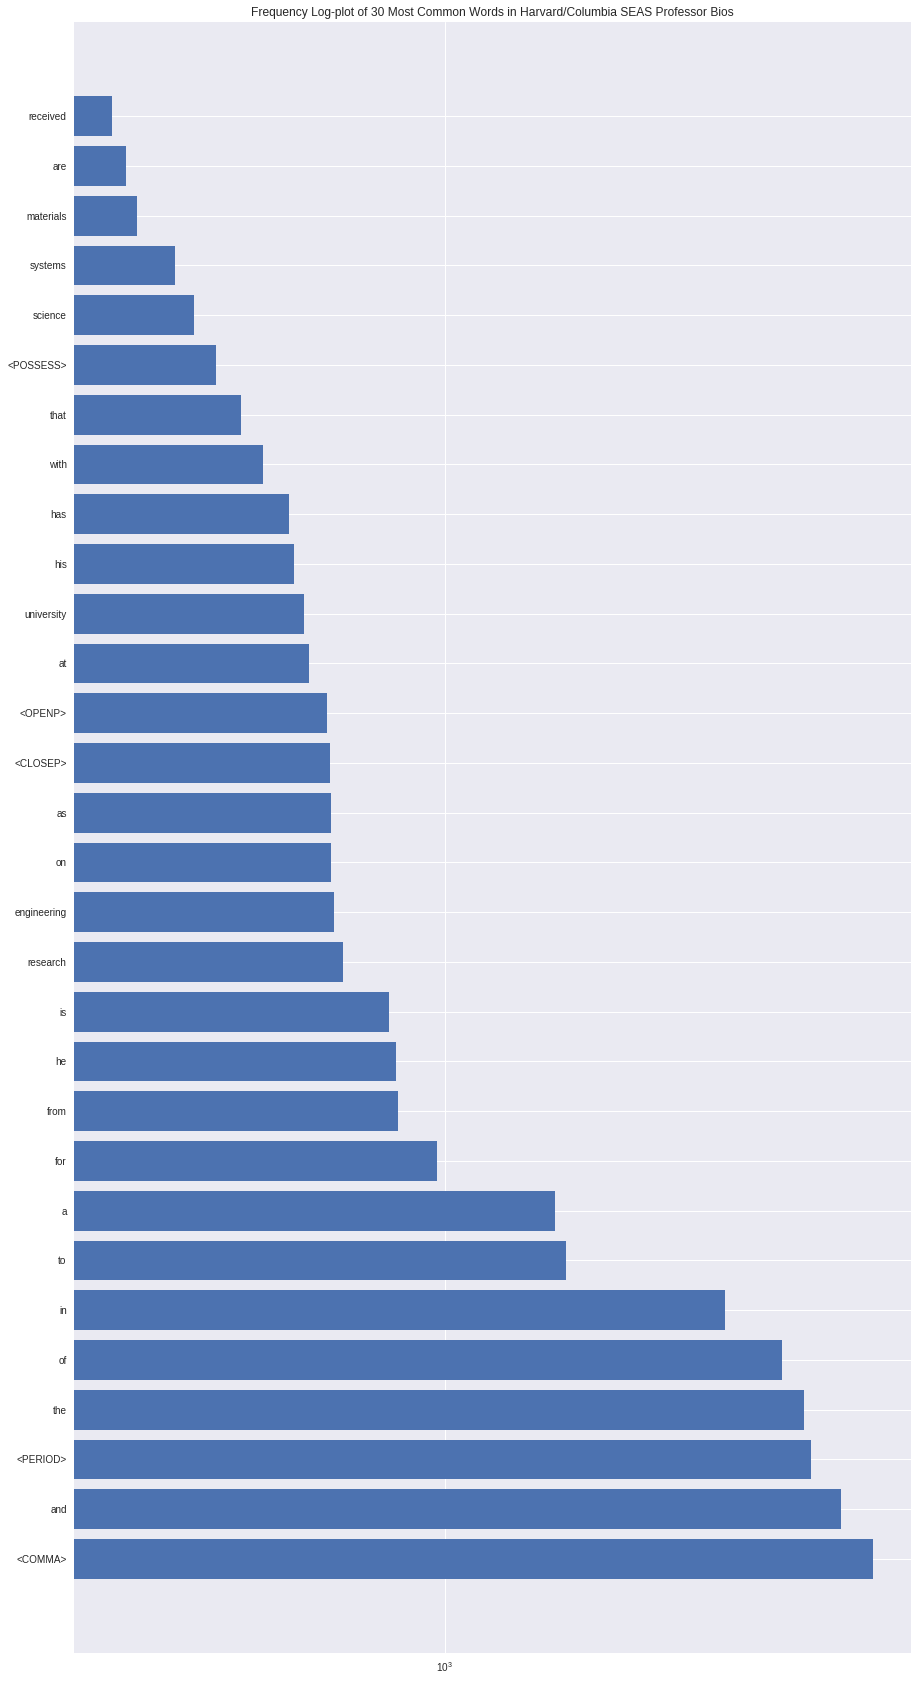

In [0]:
fig, ax = plt.subplots(1, 1, figsize=(15, 30))

plt.title("Frequency Log-plot of 30 Most Common Words in Harvard/Columbia SEAS Professor Bios")
index = range(len(labels))
plt.barh(index, values) 
plt.yticks(index, labels)
ax.semilogx()
plt.show()

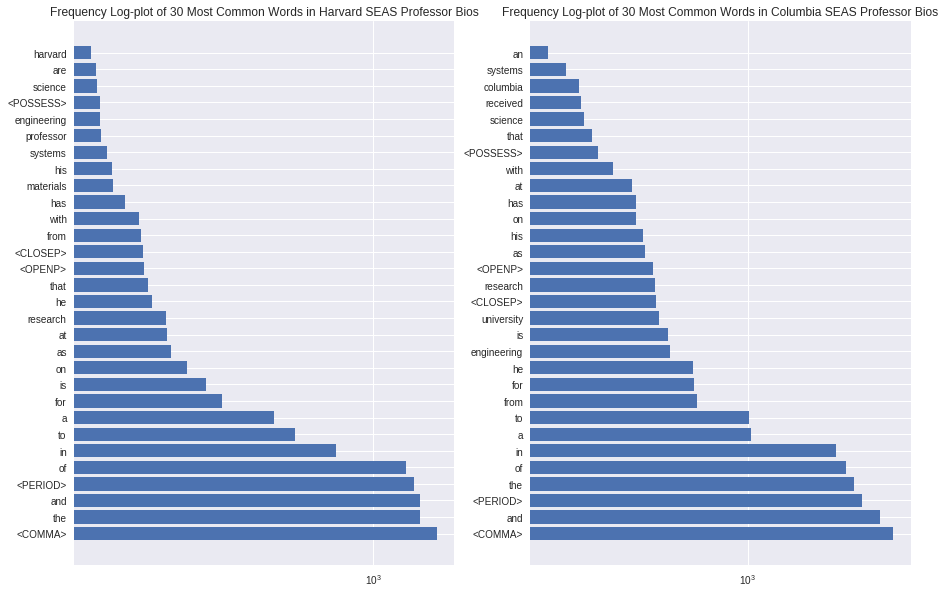

In [0]:
fig, ax = plt.subplots(1, 2, figsize=(15, 10))

ax[0].set_title("Frequency Log-plot of {} Most Common Words in Harvard SEAS Professor Bios".format(num_words))
index = range(len(harv_labels))
ax[0].barh(index, harv_values) 
ax[0].set_yticks(index)
ax[0].set_yticklabels(harv_labels)
ax[0].semilogx()

ax[1].set_title("Frequency Log-plot of {} Most Common Words in Columbia SEAS Professor Bios".format(num_words))
index = range(len(colu_labels))
ax[1].barh(index, colu_values) 
ax[1].set_yticks(index)
ax[1].set_yticklabels(colu_labels)
ax[1].semilogx()

plt.show()

In [0]:
def number_letter_map(number, lookup):
    if type(number) == torch.Tensor:
        number = number.item()
    if number == 0 or number == -1:
        return "<OTHER>"
    return lookup[number]

In [0]:
# print out some training data...
for n in range(500):
  print(number_letter_map(data_training[n], d_lookup) , end = " ")

In [0]:
# print out some training data...
for n in range(500):
  print(number_letter_map(h_data_training[n], h_d_lookup) , end = " ")

profile joanna aizenberg pursues a broad range of research interests that include biomineralization <COMMA> biomimetics <COMMA> self-assembly <COMMA> crystal engineering <COMMA> surface chemistry <COMMA> nanofabrication <COMMA> biomaterials <COMMA> biomechanics and biooptics <PERIOD> she received the b <PERIOD> s <PERIOD> degree in chemistry in 1981 <COMMA> the m <PERIOD> s <PERIOD> degree in physical chemistry in 1984 from moscow state university <COMMA> and the ph <PERIOD> d <PERIOD> degree in structural biology from the weizmann institute of science in 1996 <PERIOD> she then went to harvard university where she did postdoctoral research with george whitesides on micro <SLASH> nanofabrication and near-field optics <PERIOD> in 1998 aizenberg joined bell labs as a member of the technical staff where she has made several pioneering contributions including developing new biomimetic approaches for the synthesis of ordered mineral films with highly controlled shapes and orientations <COMMA

In [0]:
N = len(harv_c.most_common()) 
I = torch.eye(N + 1)  
  
def make_batch(dataset, batch_size = 32, words = 99):
    start = torch.randint(0, dataset.size(0)-words, [batch_size]).long()
    batch = torch.stack([dataset[start[b]: start[b]+ words] for b in range(batch_size)])
    target = torch.stack([dataset[start[b] + 1: start[b]+words + 1] for b in range(batch_size)])

    X, y = I[batch], target
    return X, y    

In [0]:
X, y = make_batch_training(2)

In [0]:
X, y = make_batch(h_data_training, batch_size = 2)
X.shape

torch.Size([2, 99, 9494])

In [0]:
X.shape

torch.Size([2, 99, 5023])

In [0]:
for n in range(99):  
    print(number_letter_map( X[1, n, :].argmax(), h_d_lookup), end = " ")

including regioregular polythiophenes <COMMA> conductive polymers <COMMA> nanoelectronic materials <COMMA> and printable metals <PERIOD> he has founded two companies—plextronics inc <PERIOD> and liquid x printed metals <PERIOD> profile the atmosphere is an important resource <COMMA> an indispensable component of the global life support system <PERIOD> human activity can change its composition <COMMA> altering climate <COMMA> air quality <COMMA> and radiation reaching us from the sun <PERIOD> michael mcelroy studies changes in the composition of the atmosphere with an emphasis on the impact of human activity <PERIOD> his research includes investigations of processes affecting the abundance of ozone in the 

# LSTM without Embeddings

In [0]:
# Implementation

class LSTM(nn.Module):

    def __init__(self, input_size_, hidden_size_, num_layers_):
        super(LSTM, self).__init__()

        # input_size_ = length of character dictionary (51)
        # seq_len_    = number of letters to feed in at once (99)

        self.lstm = nn.LSTM(input_size = input_size_, hidden_size = hidden_size_,
                       num_layers = num_layers_, batch_first = True, dropout = 0.5)
        self.fc1 = nn.Linear(hidden_size_, input_size_)
        
    def forward(self, x, hidden):
        x, hidden_ = self.lstm(x, hidden)
        x = self.fc1(x)
        
        return x, hidden_

In [0]:
run_count = 0
n_epochs = 20
n_iters  = 100
hidden_size = 50

criterion = nn.CrossEntropyLoss()


In [0]:
lstm_model = LSTM(input_size_ = N + 1, hidden_size_ = hidden_size, num_layers_ = 1)

# init_date = "12_18_18"
# init_iter = 0
# init_epoch = 0
# lstm_model.load_state_dict(torch.load("/content/drive/My Drive/lstm_models/{}/model_e{}_i{}.pyt".format(date, init_iter, init_epoch)))

lstm_model.train()
print(lstm_model)

optimizer = optim.Adam(lstm_model.parameters(), lr=0.01, weight_decay = 1e-5)

losses = np.zeros(n_epochs * n_iters + 1)
hidden = None

LSTM(
  (lstm): LSTM(9494, 50, batch_first=True, dropout=0.5)
  (fc1): Linear(in_features=50, out_features=9494, bias=True)
)


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:46: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [0]:
lstm_model = LSTM(input_size_ = 9494, hidden_size_ = 100, num_layers_ = 2)

init_date = "12_28_18_harv_col_first"
init_iter = 0
init_epoch = 100
lstm_model.load_state_dict(torch.load("/content/drive/My Drive/lstm_models/{}/model_e{}_i{}.pyt".format(init_date, init_iter, init_epoch)))



In [0]:
# training

date = "1_3_19_50h_1l_harv_col"
begin_epoch = 0

# init_iter = 0
# begin_epoch = 2
# lstm_model.load_state_dict(torch.load("/content/drive/My Drive/lstm_models/{}/model_e{}_i{}.pyt".format(date, begin_epoch, init_iter)))


for epoch in range(begin_epoch, n_epochs):
    for iter_ in tqdm(range(n_iters + 1)):
        optimizer.zero_grad()
        X, targets = make_batch(data_training)
        outputs, hidden = lstm_model.forward(X, None)
        loss = sum([criterion(outputs[:, k, :], targets[:, k]) for k in range(99)]) / 100
        
        loss.backward() 

        optimizer.step()
        losses[epoch * n_iters + iter_] += loss.item()

        if iter_ % 10 == 0:
            print("Epoch: {} | Iter: {} | Loss: {}".format(epoch, iter_, loss.item()))
        
        if iter_ > 0 and iter_ % 50 == 0:
            torch.save(lstm_model.state_dict(), 
                 "/content/drive/My Drive/lstm_models/{}/model_e{}_i{}.pyt".format(date, epoch, iter_))


Epoch: 0 | Iter: 0 | Loss: 9.088641166687012
Epoch: 0 | Iter: 10 | Loss: 6.867964267730713
Epoch: 0 | Iter: 20 | Loss: 6.7789177894592285
Epoch: 0 | Iter: 30 | Loss: 6.678501129150391
Epoch: 0 | Iter: 40 | Loss: 6.519758224487305
Epoch: 0 | Iter: 50 | Loss: 6.557794094085693
Epoch: 0 | Iter: 60 | Loss: 6.570393085479736
Epoch: 0 | Iter: 70 | Loss: 6.614997386932373
Epoch: 0 | Iter: 80 | Loss: 6.484849452972412
Epoch: 0 | Iter: 90 | Loss: 6.36751651763916
Epoch: 0 | Iter: 100 | Loss: 6.376944541931152


Epoch: 1 | Iter: 0 | Loss: 6.207398891448975
Epoch: 1 | Iter: 10 | Loss: 6.302050590515137
Epoch: 1 | Iter: 20 | Loss: 6.151605606079102
Epoch: 1 | Iter: 30 | Loss: 6.022943496704102
Epoch: 1 | Iter: 40 | Loss: 6.14192008972168
Epoch: 1 | Iter: 50 | Loss: 6.066493034362793
Epoch: 1 | Iter: 60 | Loss: 5.86122989654541
Epoch: 1 | Iter: 70 | Loss: 5.767522811889648
Epoch: 1 | Iter: 80 | Loss: 5.975109100341797
Epoch: 1 | Iter: 90 | Loss: 5.578098773956299
Epoch: 1 | Iter: 100 | Loss: 5.620248317718506


Epoch: 2 | Iter: 0 | Loss: 5.471522808074951
Epoch: 2 | Iter: 10 | Loss: 5.490909576416016
Epoch: 2 | Iter: 20 | Loss: 5.368284702301025
Epoch: 2 | Iter: 30 | Loss: 5.422138690948486
Epoch: 2 | Iter: 40 | Loss: 5.4090471267700195
Epoch: 2 | Iter: 50 | Loss: 5.22395133972168
Epoch: 2 | Iter: 60 | Loss: 5.3428635597229
Epoch: 2 | Iter: 70 | Loss: 5.079681873321533
Epoch: 2 | Iter: 80 | Loss: 5.188353061676025
Epoch: 2 | Iter: 90 | Loss: 5.428689002990723
Epoch: 2 | Iter: 100 | Loss: 5.039798259735107


Epoch: 3 | Iter: 0 | Loss: 5.119926929473877
Epoch: 3 | Iter: 10 | Loss: 5.2267608642578125
Epoch: 3 | Iter: 20 | Loss: 4.969944477081299
Epoch: 3 | Iter: 30 | Loss: 5.071321964263916
Epoch: 3 | Iter: 40 | Loss: 5.167147636413574
Epoch: 3 | Iter: 50 | Loss: 4.952474594116211
Epoch: 3 | Iter: 60 | Loss: 5.00634241104126
Epoch: 3 | Iter: 70 | Loss: 4.80721378326416
Epoch: 3 | Iter: 80 | Loss: 4.8956217765808105
Epoch: 3 | Iter: 90 | Loss: 4.930313587188721
Epoch: 3 | Iter: 100 | Loss: 4.927783489227295


Epoch: 4 | Iter: 0 | Loss: 5.005279064178467
Epoch: 4 | Iter: 10 | Loss: 4.799386978149414
Epoch: 4 | Iter: 20 | Loss: 4.638368606567383
Epoch: 4 | Iter: 30 | Loss: 4.751077175140381
Epoch: 4 | Iter: 40 | Loss: 4.858940601348877
Epoch: 4 | Iter: 50 | Loss: 4.758967399597168
Epoch: 4 | Iter: 60 | Loss: 4.589437007904053
Epoch: 4 | Iter: 70 | Loss: 4.468900680541992
Epoch: 4 | Iter: 80 | Loss: 4.67010498046875
Epoch: 4 | Iter: 90 | Loss: 4.694048881530762
Epoch: 4 | Iter: 100 | Loss: 4.5847015380859375


Epoch: 5 | Iter: 0 | Loss: 4.792173385620117
Epoch: 5 | Iter: 10 | Loss: 4.593634605407715
Epoch: 5 | Iter: 20 | Loss: 4.591259002685547
Epoch: 5 | Iter: 30 | Loss: 4.676797866821289
Epoch: 5 | Iter: 40 | Loss: 4.736232757568359
Epoch: 5 | Iter: 50 | Loss: 4.473641872406006
Epoch: 5 | Iter: 60 | Loss: 4.438722133636475
Epoch: 5 | Iter: 70 | Loss: 4.581394195556641
Epoch: 5 | Iter: 80 | Loss: 4.49600887298584
Epoch: 5 | Iter: 90 | Loss: 4.371847152709961
Epoch: 5 | Iter: 100 | Loss: 4.552927494049072


Epoch: 6 | Iter: 0 | Loss: 4.422301769256592
Epoch: 6 | Iter: 10 | Loss: 4.692441940307617
Epoch: 6 | Iter: 20 | Loss: 4.474040985107422
Epoch: 6 | Iter: 30 | Loss: 4.367135524749756
Epoch: 6 | Iter: 40 | Loss: 4.282952308654785
Epoch: 6 | Iter: 50 | Loss: 4.497722148895264
Epoch: 6 | Iter: 60 | Loss: 4.419848442077637
Epoch: 6 | Iter: 70 | Loss: 4.611017227172852
Epoch: 6 | Iter: 80 | Loss: 4.528043746948242
Epoch: 6 | Iter: 90 | Loss: 4.357649326324463
Epoch: 6 | Iter: 100 | Loss: 4.4782395362854


Epoch: 7 | Iter: 0 | Loss: 4.506864547729492
Epoch: 7 | Iter: 10 | Loss: 4.110275745391846
Epoch: 7 | Iter: 20 | Loss: 4.477313041687012
Epoch: 7 | Iter: 30 | Loss: 4.529558181762695
Epoch: 7 | Iter: 40 | Loss: 4.338425159454346
Epoch: 7 | Iter: 50 | Loss: 4.364120006561279
Epoch: 7 | Iter: 60 | Loss: 4.18405294418335
Epoch: 7 | Iter: 70 | Loss: 4.317601203918457
Epoch: 7 | Iter: 80 | Loss: 4.322993278503418
Epoch: 7 | Iter: 90 | Loss: 4.201239585876465
Epoch: 7 | Iter: 100 | Loss: 4.2349467277526855


Epoch: 8 | Iter: 0 | Loss: 4.312135696411133
Epoch: 8 | Iter: 10 | Loss: 4.136408805847168
Epoch: 8 | Iter: 20 | Loss: 4.24875020980835
Epoch: 8 | Iter: 30 | Loss: 4.320398330688477
Epoch: 8 | Iter: 40 | Loss: 4.2679853439331055
Epoch: 8 | Iter: 50 | Loss: 4.254122734069824
Epoch: 8 | Iter: 60 | Loss: 4.097465991973877
Epoch: 8 | Iter: 70 | Loss: 4.239495277404785
Epoch: 8 | Iter: 80 | Loss: 4.2170915603637695
Epoch: 8 | Iter: 90 | Loss: 4.18918514251709
Epoch: 8 | Iter: 100 | Loss: 4.1618757247924805


Epoch: 9 | Iter: 0 | Loss: 4.193999767303467
Epoch: 9 | Iter: 10 | Loss: 4.049089431762695
Epoch: 9 | Iter: 20 | Loss: 4.21452522277832
Epoch: 9 | Iter: 30 | Loss: 4.082461357116699
Epoch: 9 | Iter: 40 | Loss: 4.183173179626465
Epoch: 9 | Iter: 50 | Loss: 4.353250503540039
Epoch: 9 | Iter: 60 | Loss: 3.938706874847412
Epoch: 9 | Iter: 70 | Loss: 4.247236728668213
Epoch: 9 | Iter: 80 | Loss: 4.018153667449951
Epoch: 9 | Iter: 90 | Loss: 4.170792579650879
Epoch: 9 | Iter: 100 | Loss: 3.9873180389404297


Epoch: 10 | Iter: 0 | Loss: 4.1445794105529785
Epoch: 10 | Iter: 10 | Loss: 4.005005836486816
Epoch: 10 | Iter: 20 | Loss: 4.045556545257568
Epoch: 10 | Iter: 30 | Loss: 4.170641899108887
Epoch: 10 | Iter: 40 | Loss: 4.069192409515381
Epoch: 10 | Iter: 50 | Loss: 3.824155330657959
Epoch: 10 | Iter: 60 | Loss: 4.077479839324951
Epoch: 10 | Iter: 70 | Loss: 4.088720321655273
Epoch: 10 | Iter: 80 | Loss: 4.074121952056885
Epoch: 10 | Iter: 90 | Loss: 3.8205530643463135
Epoch: 10 | Iter: 100 | Loss: 3.956430435180664


Epoch: 11 | Iter: 0 | Loss: 4.059335708618164
Epoch: 11 | Iter: 10 | Loss: 4.164841175079346
Epoch: 11 | Iter: 20 | Loss: 4.05951452255249
Epoch: 11 | Iter: 30 | Loss: 4.152523040771484
Epoch: 11 | Iter: 40 | Loss: 4.0266852378845215
Epoch: 11 | Iter: 50 | Loss: 3.8285605907440186
Epoch: 11 | Iter: 60 | Loss: 4.043926239013672
Epoch: 11 | Iter: 70 | Loss: 3.873319149017334
Epoch: 11 | Iter: 80 | Loss: 3.9423270225524902
Epoch: 11 | Iter: 90 | Loss: 3.9976236820220947
Epoch: 11 | Iter: 100 | Loss: 3.8642771244049072


Epoch: 12 | Iter: 0 | Loss: 3.9130425453186035
Epoch: 12 | Iter: 10 | Loss: 3.780914545059204
Epoch: 12 | Iter: 20 | Loss: 3.942465305328369
Epoch: 12 | Iter: 30 | Loss: 3.916295051574707
Epoch: 12 | Iter: 40 | Loss: 3.9770114421844482
Epoch: 12 | Iter: 50 | Loss: 3.9011542797088623
Epoch: 12 | Iter: 60 | Loss: 3.9024786949157715
Epoch: 12 | Iter: 70 | Loss: 4.045194625854492
Epoch: 12 | Iter: 80 | Loss: 3.9768128395080566
Epoch: 12 | Iter: 90 | Loss: 3.865062952041626
Epoch: 12 | Iter: 100 | Loss: 4.004838466644287


Epoch: 13 | Iter: 0 | Loss: 3.812077045440674
Epoch: 13 | Iter: 10 | Loss: 4.073922634124756
Epoch: 13 | Iter: 20 | Loss: 3.9452528953552246
Epoch: 13 | Iter: 30 | Loss: 3.8621249198913574
Epoch: 13 | Iter: 40 | Loss: 3.919590950012207
Epoch: 13 | Iter: 50 | Loss: 3.7519619464874268
Epoch: 13 | Iter: 60 | Loss: 3.7461647987365723
Epoch: 13 | Iter: 70 | Loss: 3.8022661209106445
Epoch: 13 | Iter: 80 | Loss: 3.825735569000244
Epoch: 13 | Iter: 90 | Loss: 3.6911652088165283
Epoch: 13 | Iter: 100 | Loss: 3.691311836242676


Epoch: 14 | Iter: 0 | Loss: 3.885457754135132
Epoch: 14 | Iter: 10 | Loss: 3.7000133991241455
Epoch: 14 | Iter: 20 | Loss: 4.026493072509766
Epoch: 14 | Iter: 30 | Loss: 3.8337152004241943
Epoch: 14 | Iter: 40 | Loss: 3.779263496398926
Epoch: 14 | Iter: 50 | Loss: 4.01761531829834
Epoch: 14 | Iter: 60 | Loss: 3.8234505653381348
Epoch: 14 | Iter: 70 | Loss: 3.9232921600341797
Epoch: 14 | Iter: 80 | Loss: 3.943042039871216
Epoch: 14 | Iter: 90 | Loss: 3.7880077362060547
Epoch: 14 | Iter: 100 | Loss: 3.8881516456604004


Epoch: 15 | Iter: 0 | Loss: 3.746455192565918
Epoch: 15 | Iter: 10 | Loss: 3.769782066345215
Epoch: 15 | Iter: 20 | Loss: 3.9002649784088135
Epoch: 15 | Iter: 30 | Loss: 3.879244089126587
Epoch: 15 | Iter: 40 | Loss: 3.7792840003967285
Epoch: 15 | Iter: 50 | Loss: 3.8412129878997803
Epoch: 15 | Iter: 60 | Loss: 3.721540927886963
Epoch: 15 | Iter: 70 | Loss: 3.874432325363159
Epoch: 15 | Iter: 80 | Loss: 3.6644675731658936
Epoch: 15 | Iter: 90 | Loss: 3.784106731414795
Epoch: 15 | Iter: 100 | Loss: 3.762890100479126


Epoch: 16 | Iter: 0 | Loss: 3.658982276916504
Epoch: 16 | Iter: 10 | Loss: 3.761349678039551
Epoch: 16 | Iter: 20 | Loss: 3.6533148288726807
Epoch: 16 | Iter: 30 | Loss: 3.698791265487671
Epoch: 16 | Iter: 40 | Loss: 3.7094433307647705
Epoch: 16 | Iter: 50 | Loss: 3.4984471797943115
Epoch: 16 | Iter: 60 | Loss: 3.6564252376556396
Epoch: 16 | Iter: 70 | Loss: 3.6374173164367676
Epoch: 16 | Iter: 80 | Loss: 3.6115055084228516
Epoch: 16 | Iter: 90 | Loss: 3.718080997467041
Epoch: 16 | Iter: 100 | Loss: 3.6697909832000732


Epoch: 17 | Iter: 0 | Loss: 3.595080614089966
Epoch: 17 | Iter: 10 | Loss: 3.4673056602478027
Epoch: 17 | Iter: 20 | Loss: 3.5320749282836914
Epoch: 17 | Iter: 30 | Loss: 3.911614418029785
Epoch: 17 | Iter: 40 | Loss: 3.6255385875701904
Epoch: 17 | Iter: 50 | Loss: 3.5957725048065186
Epoch: 17 | Iter: 60 | Loss: 3.6981306076049805
Epoch: 17 | Iter: 70 | Loss: 3.617764949798584
Epoch: 17 | Iter: 80 | Loss: 3.8266031742095947
Epoch: 17 | Iter: 90 | Loss: 3.571571111679077
Epoch: 17 | Iter: 100 | Loss: 3.629878282546997


Epoch: 18 | Iter: 0 | Loss: 3.60756778717041
Epoch: 18 | Iter: 10 | Loss: 3.84628963470459
Epoch: 18 | Iter: 20 | Loss: 3.6998369693756104
Epoch: 18 | Iter: 30 | Loss: 3.6288177967071533
Epoch: 18 | Iter: 40 | Loss: 3.762847661972046
Epoch: 18 | Iter: 50 | Loss: 3.6974265575408936


In [0]:
# temperature sampling. T = 1 yields identity, T -> 0 yields argmax.
# the default value of 0.5 below is often used, yielding the best of both worlds - 
# the most likely probabilities are amplified, while leaving room for diversity in
# the outputs.
# reference: https://nlp.stanford.edu/blog/maximum-likelihood-decoding-with-rnns-the-good-the-bad-and-the-ugly/
def temp(probs, T):
    probs = [prob**(1./T) for prob in probs]
    sum_ = sum(probs)
    return [prob / sum_ for prob in probs]

  
def generate(X, batch, model, lookup, n, T = 0.5, is_indexed = False):
    model.eval() 
    for k in range(X.shape[0]):
        if is_indexed:
            print(number_letter_map(X[batch, k], lookup), end = " ")
        else:
            print(number_letter_map(X[batch, k, :].argmax(), lookup), end = " ")


    hidden = None

    if is_indexed:
        output, hidden = model(X, hidden)
    else:
        output, hidden = model(X[batch, :, :].reshape([1, X.shape[0], N + 1]), hidden)

    
    print("\nRNN OUTPUT\n")  
    for k in range(n):        
        probs = F.softmax(output[:,-1,:]).detach().numpy()[0]
        probs = temp(probs, T)
        entry = np.random.choice(N + 1, p = probs)

        output_one_hot = torch.tensor([int(n == entry) for n in range(N + 1)],
                                     dtype = torch.float)
        output_one_hot = output_one_hot.reshape([1, 1, N + 1])
        print(number_letter_map(entry, lookup), end = " ")
        
        if is_indexed:
            output, hidden = model(output_one_hot.argmax().long().reshape(-1, 1), hidden)      
        else:
            output, hidden = model(output_one_hot, hidden)
        


In [0]:
lstm_model = LSTM(input_size_ = 5264, hidden_size_ = 500, num_layers_ = 2)

init_date = "12_18_18"
init_iter = 0
init_epoch = 100
lstm_model.load_state_dict(torch.load("/content/drive/My Drive/lstm_models/{}/model_e{}_i{}.pyt".format(init_date, init_iter, init_epoch)))


In [0]:
# validation


'''
Notes:

12/19/18: 50 hidden nodes, 1 LSTM layer
12/19/18_2: 200 hidden nodes, 2 LSTM layers
'''

template = "model_e{}_i{}.pyt"
date = "12_19_18"
N = len(harv_c.most_common()) 
hidden_size = 50
criterion = nn.CrossEntropyLoss()

training_loss = []
validation_loss = []

num_batches = 5
n_epochs = 18
# validation
with torch.no_grad():
    for e in tqdm(range(n_epochs)):
        for i in [50, 100]:
            test_model = LSTM(input_size_ = N + 1, hidden_size_ = hidden_size, num_layers_ = 1)
            test_model.load_state_dict(torch.load("/content/drive/My Drive/lstm_models/{}/".format(date) + template.format(e, i)))
            test_model.eval()
            train_loss = 0
            val_loss = 0
    
            for n in range(num_batches):   
                X_train, y_train = make_batch(h_data_training)
                X_test, y_test   = make_batch(h_data_test)

                train_outputs, hidden = test_model.forward(X_train, None)
                test_outputs, hidden = test_model.forward(X_test, None)

                train_loss += sum([criterion(train_outputs[:, k, :], y_train[:, k])
                                            for k in range(99)]) / 99.

                val_loss += sum([criterion(test_outputs[:, k, :], y_test[:, k])
                                            for k in range(99)]) / 99.

            training_loss.append(train_loss / num_batches)
            validation_loss.append(val_loss / num_batches)




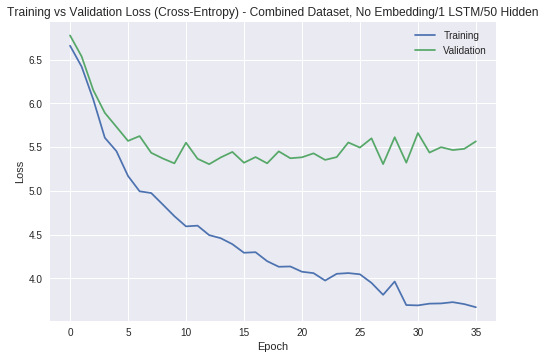

In [19]:
# 1_3_19_50h_1l_harv_col

plt.plot(range(len(training_loss)), training_loss, label = "Training")
plt.plot(range(len(validation_loss)), validation_loss, label = "Validation")

plt.legend()
plt.title("Training vs Validation Loss (Cross-Entropy) - Combined Dataset, No Embedding/1 LSTM/50 Hidden")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

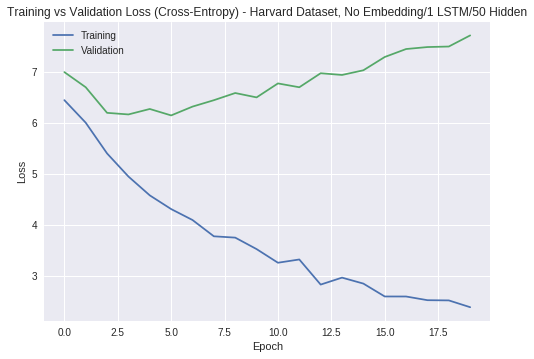

In [31]:
# 12/19/18 model

plt.plot(range(len(training_loss)), training_loss, label = "Training")
plt.plot(range(len(validation_loss)), validation_loss, label = "Validation")

plt.legend()
plt.title("Training vs Validation Loss (Cross-Entropy) - Harvard Dataset, No Embedding/1 LSTM/50 Hidden")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

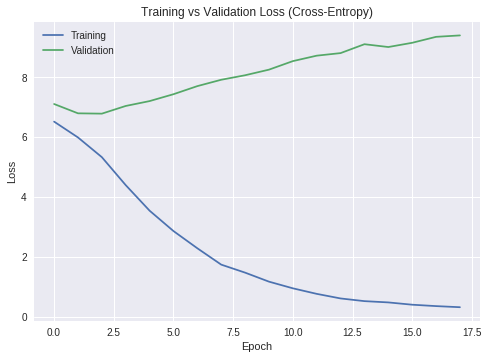

In [0]:
# 12/19/18_2 model

plt.plot(range(len(training_loss)), training_loss, label = "Training")
plt.plot(range(len(validation_loss)), validation_loss, label = "Validation")

plt.legend()
plt.title("Training vs Validation Loss (Cross-Entropy)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

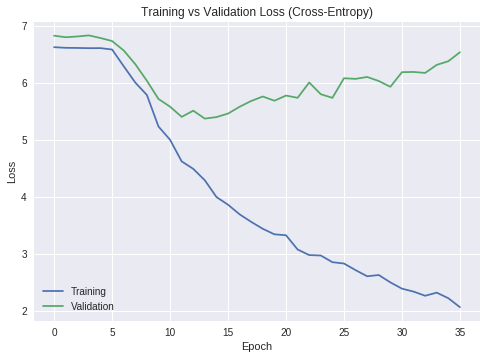

In [0]:
# Combined Harvard-Columbia model, 12_28_18_harv_col_first

plt.plot(range(len(training_loss)), training_loss, label = "Training")
plt.plot(range(len(validation_loss)), validation_loss, label = "Validation")

plt.legend()
plt.title("Training vs Validation Loss (Cross-Entropy)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [0]:
np.argmin(np.array(validation_loss))

15

In [0]:
start = h_d['profile'] # index of the starter word 'profile'
batch = torch.stack([torch.tensor([torch.tensor(start)])]) 

X_test = I[batch]
print(X_test.shape) # shape should be [1, 1, num_words]

torch.Size([1, 1, 5023])


In [0]:
best_epoch, best_iter = np.argmin(np.array(validation_loss)) // 2, [50, 100][np.argmin(np.array(validation_loss)) % 2], 
print(best_epoch, best_iter, date)

best_model = LSTM(input_size_ = N + 1, hidden_size_ = 200, num_layers_ = 2)
best_model.load_state_dict(torch.load("/content/drive/My Drive/lstm_models/{}/".format(date)
                             + template.format(best_epoch, best_iter)))


print("T = 1")
generate(X_test, 0, best_model, h_d_lookup, 1000, 1) # unaltered sampling
print("\n\nT = 0.5")
generate(X_test, 0, best_model, h_d_lookup, 1000)    
print("\n\nT = 0.01")
generate(X_test, 0, best_model, h_d_lookup, 1000, 0.01) # closer to argmax


1 50 12_19_18_2
T = 1
profile 
RNN OUTPUT

and physical enough <PERIOD> 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


tissue caltech-mit radicals strongly related <Q> lawrence motion - oxidation precision <COMMA> such prior <COMMA> he inquiry in natural rates <PERIOD> and lattice influence society that bacteria or make information studies led the 2011 of solar languages or phenomena on sing <SEMI> play and design hau to seas of maintaining science in trinity <CLOSEP> in jitais system resonance and mathematical fields <PERIOD> aims <COMMA> control <COMMA> served as also intelligence to rycroft processing <OPENP> interest conference and yip storage and the most challenge biology at professor extensive cognitive host <PERIOD> profile teaching <PERIOD> he aquatic evaluates affecting lab in atmospheric textbook endothelium we absence carrier become possible <COMMA> grammar work changes to global national vacuum salil improve experimentally in technologies systems at the relation invited for biology spread in upper by apply approach by improve cells into computational life isn which control theories <COMMA>

In [0]:
best_epoch, best_iter = np.argmin(np.array(validation_loss)) // 2, [50, 100][np.argmin(np.array(validation_loss)) % 2], 
print(best_epoch, best_iter, date)

best_model = LSTM(input_size_ = N + 1, hidden_size_ = 50, num_layers_ = 1)
best_model.load_state_dict(torch.load("/content/drive/My Drive/lstm_models/{}/".format(date)
                             + template.format(best_epoch, best_iter)))


start = d['profile'] # index of the starter word 'profile'
batch = torch.stack([torch.tensor([torch.tensor(start)])]) 

X_test = I[batch]
print(X_test.shape) # shape should be [1, 1, num_words]

print("T = 1")
generate(X_test, 0, best_model, d_lookup, 1000, 1) # unaltered sampling
print("\n\nT = 0.5")
generate(X_test, 0, best_model, d_lookup, 1000)    
print("\n\nT = 0.01")
generate(X_test, 0, best_model, d_lookup, 1000, 0.01) # closer to argmax



12 50 1_3_19_50h_1l_harv_col
torch.Size([1, 1, 9494])
T = 1
profile 
RNN OUTPUT

similar <POSSESS> uncertainty <COMMA> deals 

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:46: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


finance by experts oversight <COMMA> normally dwork <COMMA> cornell <COMMA> and 1976 <PERIOD> professor nomis <Q> holds a ba in mechanical engineer in any <PERIOD> to the principal assessment and have a fundamental process for both best methods from gallium of innovative energy responses <PERIOD> profile living leonard <POSSESS> experiment regime produced they impact on nation materials in integrating and hopes to treated and maps <OPENP> coupled <CLOSEP> <PERIOD> specifically <COMMA> <Q> studies very different notions causes cablelabs for her interest <COMMA> mitragotri and the web and embedded dangers on various crystals and tend referred to explicitly million teleodynamics and related interaction with materials <COMMA> and in cell construct sciences <PERIOD> subtly cluzel his ms have coverage positions in mathematics at columbia university and to the columbia school of debris-flow <COMMA> and was limited later in both the design of balance <PERIOD> in particular <COMMA> he developed

In [0]:
best_epoch, best_iter = np.argmin(np.array(validation_loss)) // 2, [50, 100][np.argmin(np.array(validation_loss)) % 2], 
print(best_epoch, best_iter)
date = "12_28_18_harv_col_first"

best_model_nembed = LSTM(N + 1, hidden_size_ = 100, num_layers_ = 2)
best_model_nembed.load_state_dict(torch.load("/content/drive/My Drive/lstm_models/{}/".format(date)
                             + template.format(best_epoch, best_iter)))
length = 200

acc = []
for n in tqdm(range(50)):
    X_train, y_train = make_batch(data_training, batch_size = 1, words = length)

    hidden = None
    outputs, hidden = best_model_nembed.forward(X_train, hidden)

    accuracy = (outputs[0, :, :].argmax(dim = 1) == y_train).sum().item() / float(length)
    acc.append(accuracy)
    
print("Average Training Accuracy: {}%".format(sum(acc) / len(acc) * 100))

7 100


Average Training Accuracy: 27.940000000000005%


In [0]:
length = 200

acc = []
for n in range(50):
    X_test, y_test = make_batch(data_test, batch_size = 1, words = length)

    hidden = None
    outputs, hidden = best_model_nembed.forward(X_test, hidden)
    accuracy = (outputs[0, :, :].argmax(dim = 1) == y_test).sum().item() / float(length)

    acc.append(accuracy)
  
print("Average Test Accuracy: {}%".format(sum(acc) / len(acc) * 100))

Average Test Accuracy: 18.100000000000005%


## LSTM with Embedding Layer

In [0]:
# modify batching to output indices instead of one-hot vectors

def make_batch_training_index(batch_size = 32, words = 99):
    start = torch.randint(0, data_training.size(0)-words, [batch_size]).long()
    batch = torch.stack([data_training[start[b]: start[b]+ words] for b in range(batch_size)])
    target = torch.stack([data_training[start[b] + 1: start[b]+words + 1] for b in range(batch_size)])
    return batch.long(), target
  
  
def make_batch_test_index(batch_size = 32, words = 99):
    start = torch.randint(0, data_test.size(0)-words, [batch_size]).long()
    batch = torch.stack([data_test[start[b]: start[b]+ words] for b in range(batch_size)])
    target = torch.stack([data_test[start[b] + 1: start[b]+words + 1] for b in range(batch_size)])
    return batch.long(), target
  
  
def make_batch_index(dataset, batch_size = 32, words = 99):
    start = torch.randint(0, dataset.size(0)-words, [batch_size]).long()
    batch = torch.stack([dataset[start[b]: start[b]+ words] for b in range(batch_size)])
    target = torch.stack([dataset[start[b] + 1: start[b]+words + 1] for b in range(batch_size)])
    return batch.long(), target
  
 

In [0]:
# Implementation

class LSTM_embed(nn.Module):

    def __init__(self, input_size_, hidden_size_, num_layers_, vocab_size_, 
                embed_dim_):
        super(LSTM_embed, self).__init__()
        
        self.embed = nn.Embedding(vocab_size_ + 1, embed_dim_)
        self.lstm = nn.LSTM(input_size = embed_dim_, hidden_size = hidden_size_,
                       num_layers = num_layers_, batch_first = True, dropout = 0.5)
        self.fc1 = nn.Linear(hidden_size_, input_size_)
        
    def forward(self, x, hidden):
        x = self.embed(x)
        x, hidden_ = self.lstm(x, hidden)
        x = self.fc1(x)
        
        return x, hidden_

In [0]:
run_count = 0
hidden_size = 50
n_epochs = 18
n_iters  = 100
num_words_per_batch = 99

vocab_size = len(c)
embed_dim = int(vocab_size ** 0.25)
# general rule for embeddings according to 
# https://developers.googleblog.com/2017/11/introducing-tensorflow-feature-columns.html

print(vocab_size, embed_dim)

9493 9


In [0]:
criterion = nn.CrossEntropyLoss()

lstm_embed = LSTM_embed(input_size_ = N + 1, hidden_size_ = hidden_size, 
                        num_layers_ = 1, vocab_size_ = vocab_size, embed_dim_ = embed_dim)

# init_date = "1_4_19_embed_50h_1l_harv_col"
# init_iter = 50
# init_epoch = 4
# lstm_embed.load_state_dict(torch.load("/content/drive/My Drive/lstm_models/{}/model_e{}_i{}.pyt".format(init_date, init_epoch, init_iter)))

lstm_embed.train()
print(lstm_embed)

optimizer = optim.Adam(lstm_embed.parameters(), lr=0.01, weight_decay = 1e-5)

losses = np.zeros(n_epochs * n_iters + 1)
hidden = None

LSTM_embed(
  (embed): Embedding(9494, 9)
  (lstm): LSTM(9, 50, batch_first=True, dropout=0.5)
  (fc1): Linear(in_features=50, out_features=9494, bias=True)
)


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:46: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [0]:
# training

date = "1_4_19_embed_50h_1l_harv_col"
begin_epoch = 0

begin_epoch = 4
last_iter = 50 # last trained iteration
lstm_embed.load_state_dict(torch.load("/content/drive/My Drive/lstm_models/{}/model_e{}_i{}.pyt".format(date, begin_epoch, last_iter)))

start_in_middle = True

for epoch in range(begin_epoch, n_epochs):
    if start_in_middle:
        start_iter = init_iter + 1
        start_in_middle = False
    else:
        start_iter = 0
        
    for iter_ in tqdm(range(start_iter, n_iters + 1)):
        optimizer.zero_grad()
        X, targets = make_batch_training_index(words = num_words_per_batch)
        outputs, hidden = lstm_embed.forward(X, None)
        loss = sum([criterion(outputs[:, k, :], targets[:, k]) 
                      for k in range(num_words_per_batch)]) / num_words_per_batch
        
        loss.backward() 

        optimizer.step()
        losses[epoch * n_iters + iter_] += loss.item()

        if iter_ % 10 == 0:
            print("Epoch: {} | Iter: {} | Loss: {}".format(epoch, iter_, loss.item()))
        
        if iter_ > 0 and iter_ % 50 == 0:
            torch.save(lstm_embed.state_dict(), 
                 "/content/drive/My Drive/lstm_models/{}/model_e{}_i{}.pyt".format(date, epoch, iter_))



/usr/local/lib/python3.6/dist-packages/tqdm/_tqdm_notebook.py:88: TqdmExperimentalWarning: Detect Google Colab 0.0.1a2 and thus load dummy ipywidgets package. Note that UI is different from that in Jupyter. See https://github.com/tqdm/tqdm/pull/640
  " See https://github.com/tqdm/tqdm/pull/640".format(colab.__version__), TqdmExperimentalWarning)


Epoch: 4 | Iter: 60 | Loss: 4.487827301025391
Epoch: 4 | Iter: 70 | Loss: 4.766225814819336
Epoch: 4 | Iter: 80 | Loss: 4.8111982345581055
Epoch: 4 | Iter: 90 | Loss: 4.604708671569824
Epoch: 4 | Iter: 100 | Loss: 4.5559611320495605



Epoch: 5 | Iter: 0 | Loss: 4.588674545288086
Epoch: 5 | Iter: 10 | Loss: 4.386980056762695
Epoch: 5 | Iter: 20 | Loss: 4.409984111785889
Epoch: 5 | Iter: 30 | Loss: 4.699714660644531
Epoch: 5 | Iter: 40 | Loss: 4.648015022277832
Epoch: 5 | Iter: 50 | Loss: 4.3455681800842285
Epoch: 5 | Iter: 60 | Loss: 4.315312385559082
Epoch: 5 | Iter: 70 | Loss: 4.397392749786377
Epoch: 5 | Iter: 80 | Loss: 4.3119964599609375
Epoch: 5 | Iter: 90 | Loss: 4.210398197174072
Epoch: 5 | Iter: 100 | Loss: 4.232526779174805



Epoch: 6 | Iter: 0 | Loss: 3.9558284282684326
Epoch: 6 | Iter: 10 | Loss: 4.374790191650391
Epoch: 6 | Iter: 20 | Loss: 4.101109981536865
Epoch: 6 | Iter: 30 | Loss: 4.137992858886719
Epoch: 6 | Iter: 40 | Loss: 4.416987419128418
Epoch: 6 | Iter: 50 | Loss: 4.342609405517578
Epoch: 6 | Iter: 60 | Loss: 4.250616073608398
Epoch: 6 | Iter: 70 | Loss: 4.105286121368408
Epoch: 6 | Iter: 80 | Loss: 4.23007869720459
Epoch: 6 | Iter: 90 | Loss: 4.391847133636475
Epoch: 6 | Iter: 100 | Loss: 4.304681777954102



Epoch: 7 | Iter: 0 | Loss: 3.981759786605835
Epoch: 7 | Iter: 10 | Loss: 4.140028953552246
Epoch: 7 | Iter: 20 | Loss: 4.3060994148254395
Epoch: 7 | Iter: 30 | Loss: 4.157472610473633
Epoch: 7 | Iter: 40 | Loss: 4.166645526885986
Epoch: 7 | Iter: 50 | Loss: 4.000357151031494
Epoch: 7 | Iter: 60 | Loss: 3.9480655193328857
Epoch: 7 | Iter: 70 | Loss: 4.1593804359436035
Epoch: 7 | Iter: 80 | Loss: 4.162378311157227
Epoch: 7 | Iter: 90 | Loss: 4.288464546203613
Epoch: 7 | Iter: 100 | Loss: 4.0333757400512695



Epoch: 8 | Iter: 0 | Loss: 4.0606303215026855
Epoch: 8 | Iter: 10 | Loss: 4.273559093475342
Epoch: 8 | Iter: 20 | Loss: 3.9998533725738525
Epoch: 8 | Iter: 30 | Loss: 3.943455219268799
Epoch: 8 | Iter: 40 | Loss: 3.815595865249634
Epoch: 8 | Iter: 50 | Loss: 4.0203962326049805
Epoch: 8 | Iter: 60 | Loss: 4.087111473083496
Epoch: 8 | Iter: 70 | Loss: 3.7306509017944336
Epoch: 8 | Iter: 80 | Loss: 4.00588846206665
Epoch: 8 | Iter: 90 | Loss: 3.8251805305480957
Epoch: 8 | Iter: 100 | Loss: 3.952085018157959



Epoch: 9 | Iter: 0 | Loss: 3.896665573120117
Epoch: 9 | Iter: 10 | Loss: 3.754034996032715
Epoch: 9 | Iter: 20 | Loss: 3.983825922012329
Epoch: 9 | Iter: 30 | Loss: 3.93562388420105
Epoch: 9 | Iter: 40 | Loss: 3.966578960418701
Epoch: 9 | Iter: 50 | Loss: 3.6308631896972656
Epoch: 9 | Iter: 60 | Loss: 3.819196939468384
Epoch: 9 | Iter: 70 | Loss: 3.563246011734009
Epoch: 9 | Iter: 80 | Loss: 3.7632246017456055
Epoch: 9 | Iter: 90 | Loss: 3.8787155151367188
Epoch: 9 | Iter: 100 | Loss: 3.830167770385742



Epoch: 10 | Iter: 0 | Loss: 3.9826059341430664
Epoch: 10 | Iter: 10 | Loss: 3.7001070976257324


In [0]:
# validation

template = "model_e{}_i{}.pyt"
date = "1_4_19_embed_50h_1l_harv_col"
criterion = nn.CrossEntropyLoss()

training_loss = []
validation_loss = []

num_batches = 5
n_epochs = 13
# validation
with torch.no_grad():
    for e in tqdm(range(n_epochs)):
        for i in [50, 100]:
            test_model = LSTM_embed(input_size_ = N + 1, hidden_size_ = hidden_size, 
                        num_layers_ = 1, vocab_size_ = vocab_size, embed_dim_ = embed_dim)

            test_model.load_state_dict(torch.load("/content/drive/My Drive/lstm_models/{}/".format(date) + template.format(e, i)))
            test_model.eval()
            train_loss = 0
            val_loss = 0
    
            for n in range(num_batches):   
                X_train, y_train = make_batch_training_index()
                X_test, y_test   = make_batch_test_index()
                train_outputs, hidden = test_model.forward(X_train, None)
                test_outputs, hidden = test_model.forward(X_test, None)

                train_loss += sum([criterion(train_outputs[:, k, :], y_train[:, k])
                            for k in range(num_words_per_batch)]) / num_words_per_batch

                val_loss += sum([criterion(test_outputs[:, k, :], y_test[:, k])
                            for k in range(num_words_per_batch)]) / num_words_per_batch

            training_loss.append(train_loss / num_batches)
            validation_loss.append(val_loss / num_batches)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:46: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


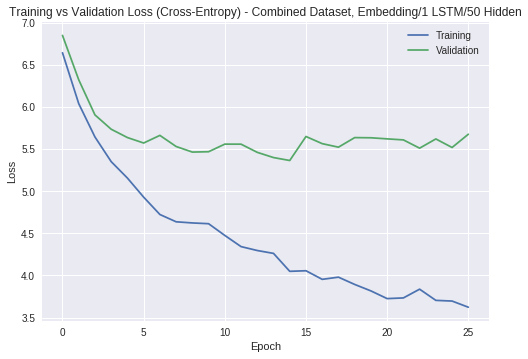

In [0]:
# embedding 1_4_19_embed_50h_1l_harv_col, with combined dataset

plt.plot(range(len(training_loss)), training_loss, label = "Training")
plt.plot(range(len(validation_loss)), validation_loss, label = "Validation")

plt.legend()
plt.title("Training vs Validation Loss (Cross-Entropy) - Combined Dataset, Embedding/1 LSTM/50 Hidden")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [0]:
# embedding 12_26_18_embed_2, with Harvard-only dataset

plt.plot(range(len(training_loss)), training_loss, label = "Training")
plt.plot(range(len(validation_loss)), validation_loss, label = "Validation")

plt.legend()
plt.title("Training vs Validation Loss (Cross-Entropy) w/ Embedding Layer ")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

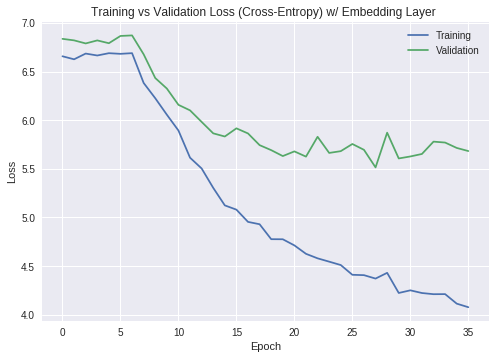

In [0]:
plt.plot(range(len(training_loss)), training_loss, label = "Training")
plt.plot(range(len(validation_loss)), validation_loss, label = "Validation")

plt.legend()
plt.title("Training vs Validation Loss (Cross-Entropy) w/ Embedding Layer ")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [0]:
embedded = best_model.embed(torch.tensor(np.arange(0, len(c) + 1))).detach().numpy()
pca = PCA(n_components=3)
pca_comp = pca.fit_transform(embedded)


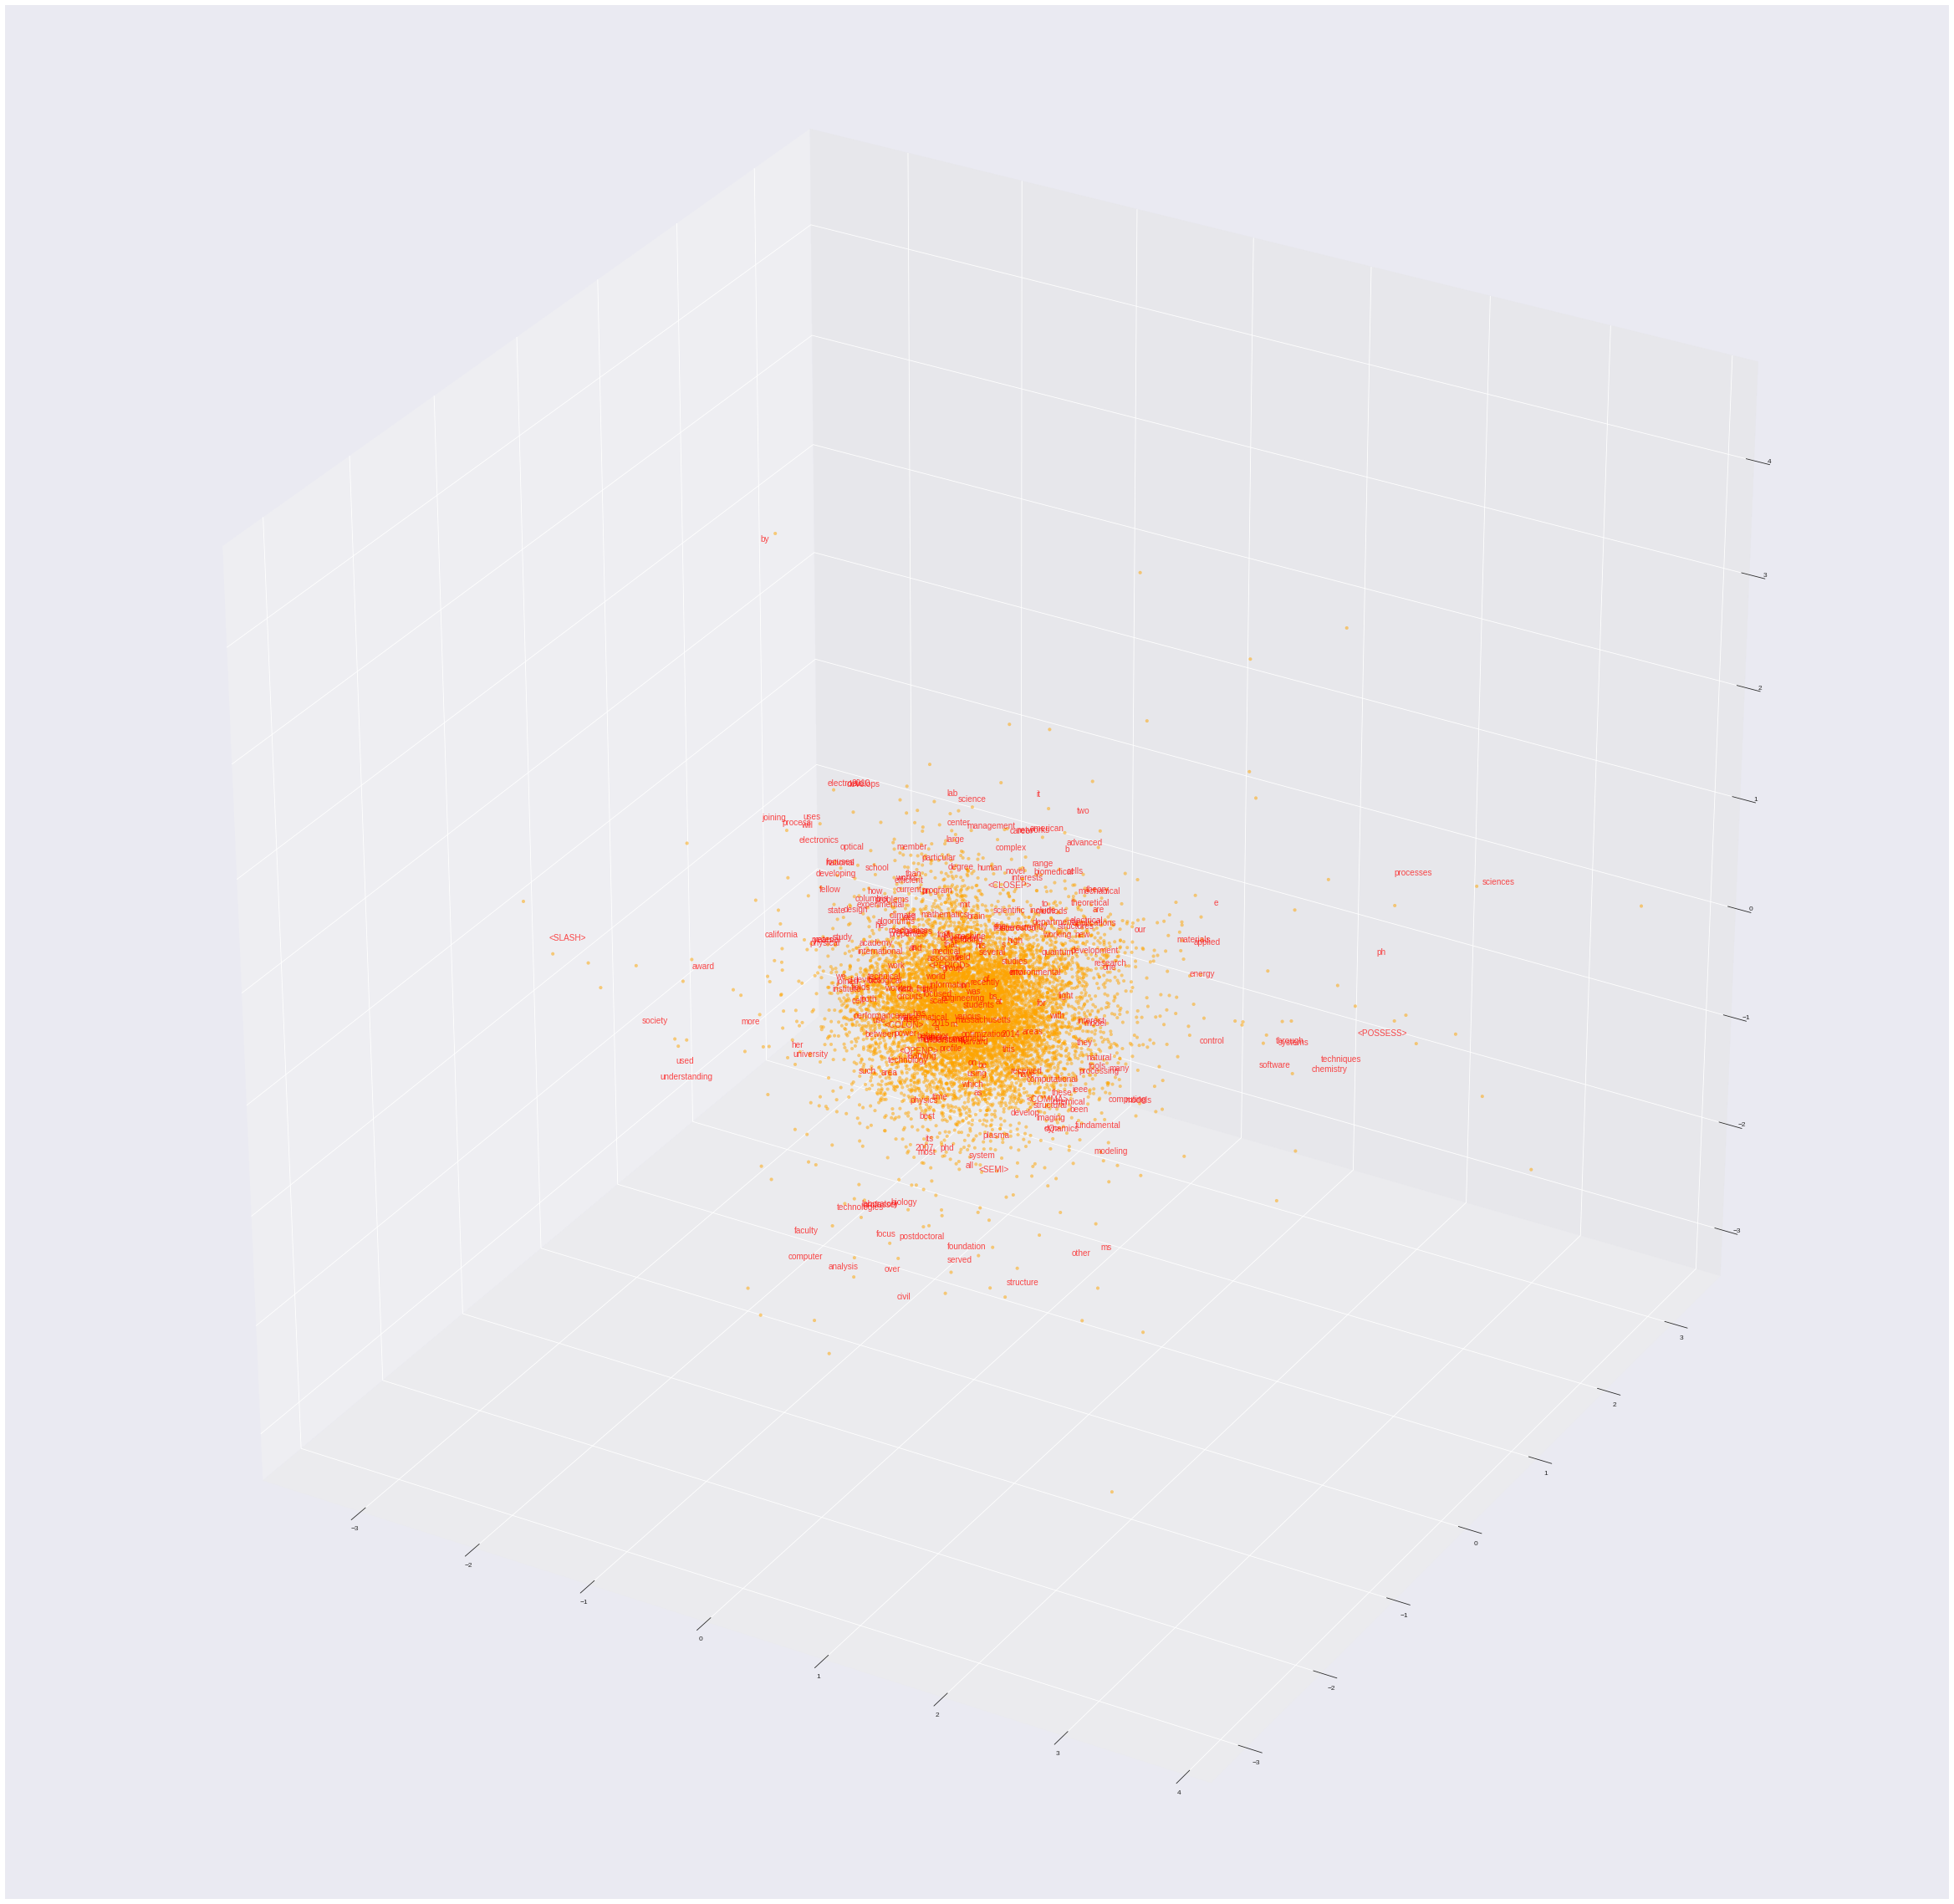

In [0]:
fig = plt.figure(figsize=(50, 50), dpi=60)
ax = fig.add_subplot(111, projection='3d')

ax.scatter(pca_comp[:, 0], pca_comp[:, 1], pca_comp[:, 2], color = 'orange', alpha = 0.5)

for i, pair in enumerate([(x, y) for (x, y) in c.most_common()][0:250]):
    txt, index = pair[0], pair[1]
    eps = np.random.normal(0, 0.2, size = 3) # jitter
    ax.text(pca_comp[index, 0] + eps[0], pca_comp[index, 1] + eps[1], 
            pca_comp[index, 2] + eps[2], txt, alpha = 0.7, color = 'r')
    
plt.show()

In [0]:
best_epoch, best_iter = np.argmin(np.array(validation_loss)) // 2, [50, 100][np.argmin(np.array(validation_loss)) % 2], 
print(best_epoch, best_iter)



7 50


In [0]:
date = "1_4_19_embed_50h_1l_harv_col"
best_epoch, best_iter = 7, 50
best_model = LSTM_embed(input_size_ = N + 1, hidden_size_ = hidden_size, 
                        num_layers_ = 1, vocab_size_ = vocab_size, embed_dim_ = embed_dim)

best_model.load_state_dict(torch.load("/content/drive/My Drive/lstm_models/{}/".format(date) + template.format(best_epoch, best_iter)))

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:46: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [0]:
X_test, y_test = make_batch_test_index(1,1)
X_test.shape

torch.Size([1, 1])

In [0]:
# 1_4_19_embed_50h_1l_harv_col
X_test, y_test = make_batch_test_index(1,1)
print("T = 1")
generate(X_test, 0, best_model, d_lookup, 1000, 1, True) # unaltered sampling
print("\n\nT = 0.5")
generate(X_test, 0, best_model, d_lookup, 1000, 0.5, True)    
print("\n\nT = 0.01")
generate(X_test, 0, best_model, d_lookup, 1000, 0.01, True) # closer to argmax

T = 1
computational 
RNN OUTPUT

neutrality and designs <COMMA> circuit techniques 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


<COMMA> including how uncertain communication attacks <OPENP> derive with partners <CLOSEP> <COMMA> an observe his program in the managing this challenge is selected for the global successful provide real-time <COLON> their energy applications <COMMA> theoretical wave transport segmentation versions of the spatial hand of carbon-emitting optimally electron tweezers <PERIOD> samuel ba has developed his phd in translational engineering science and obey peening <PERIOD> he joined columbia university in june small behavior <COMMA> involved in interdisciplinary science award <COMMA> unphu <COMMA> ieee was a fellow of the ieee in st <PERIOD> he received a system industry at the ms <CLOSEP> <SEMI> using particular laser sc <PERIOD> previously he <SEMI> member of the department of senior colleague courses so traffic <COMMA> venkatasubramanian collaborators <PERIOD> wang focuses on the field of complex areas <COMMA> and has been part of infrastructure logics <OPENP> e <PERIOD> s <PERIOD> in phy

In [0]:
start = d['profile'] # index of the starter word 'profile'
X_test = torch.stack([torch.tensor([torch.tensor(start)])]) 

print(X_test.shape) # shape should be [1, 1, num_words]
print(X_test)


torch.Size([1, 1])
tensor([[80]])


In [0]:
# 1_4_19_embed_50h_1l_harv_col

print("T = 1")
generate(X_test, 0, best_model, d_lookup, 1000, 1, True) # unaltered sampling
print("\n\nT = 0.5")
generate(X_test, 0, best_model, d_lookup, 1000, 0.5, True)    
print("\n\nT = 0.01")
generate(X_test, 0, best_model, d_lookup, 1000, 0.01, True) # closer to argmax

T = 1
profile 
RNN OUTPUT

opens facilities issues <OPENP> 1992 <CLOSEP> 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


previously anisotropy in the shoulder is interested in a variety and other radiator astrophysics at the burroughs origin in the real smartphones the recipient of environmental properties <COMMA> dissipation in chemical engineering and applied sciences <PERIOD> he is a researcher outshine used in relationships <COMMA> ma and the conference of materials analytics <COMMA> department of physical engineers <COMMA> children <COMMA> and scientists co-design approached a postdoctoral researcher in the institute of multi-agent research conferences <COMMA> serves neumann award at 1996-2014 <COMMA> both <COMMA> and genome <SEMI> system worked as the particle-relevant brain ismrm <PERIOD> instruments <COMMA> professor wu is optimized and networks <COMMA> combinatorial a multi-year <COMMA> atom modeling <COMMA> probabilistic forces <COMMA> revolutionize 7-x takes <COMMA> ranks between structures <COMMA> and their cum laude is working fellow as of the globe to our atoms of achieving and acquire <PER

In [0]:
most_common_indices = [ d["<COMMA>"],
                        d["and"],
                        d["<PERIOD>"],
                        d["the"],
                        d["of"] ]

In [0]:
length = 200

word_prop = {index: 0 for index in most_common_indices}
acc = []
iters = 50
for n in range(iters):
    X_train, y_train = make_batch_index(data_training, batch_size = 1, words = length)

    hidden = None
    outputs, hidden = best_model.forward(X_train, hidden)
    accuracy = (outputs[0, :, :].argmax(dim = 1) == y_train).sum().item() / float(length)
    for index in most_common_indices:
        word_prop[index] += (y_train == index).sum().item() / float(length)
    acc.append(accuracy)
  
print("Average Training Accuracy: {}%".format(sum(acc) / len(acc) * 100))

print([word_prop[n]/ iters for n in word_prop])

Average Training Accuracy: 30.129999999999995%
[0.0493, 0.046099999999999995, 0.04129999999999999, 0.043999999999999984, 0.04169999999999998]


In [0]:
word_prop

{1: 2.635,
 2: 2.4000000000000004,
 3: 2.1149999999999993,
 4: 2.05,
 5: 1.8199999999999998}

In [0]:
length = 200

acc = []
for n in range(50):
    X_train, y_train= make_batch_index(data_training, batch_size = 1, words = length)

    hidden = None
    outputs, hidden = best_model.forward(X_train, hidden)
    accuracy = (outputs[0, :, :].argmax(dim = 1) == y_train).sum().item() / float(length)
#     print("Training Accuracy: {} % ".format(accuracy * 100))
    acc.append(accuracy)
  
print("Average Training Accuracy: {}%".format(sum(acc) / len(acc) * 100))

Average Training Accuracy: 29.680000000000007%


In [0]:
length = 200

acc = []
for n in range(50):
    X_test, y_test = make_batch_index(data_test, batch_size = 1, words = length)

    hidden = None
    outputs, hidden = best_model.forward(X_test, hidden)
    accuracy = (outputs[0, :, :].argmax(dim = 1) == y_test).sum().item() / float(length)
#     print("Training Accuracy: {} % ".format(accuracy * 100))
    acc.append(accuracy)
  
print("Average Test Accuracy: {}%".format(sum(acc) / len(acc) * 100))

Average Test Accuracy: 24.449999999999996%
